In [32]:
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

from google.colab import files


uploaded = files.upload()


Saving Monthly gasoline demand Ontario gallon millions 1960  1975.csv to Monthly gasoline demand Ontario gallon millions 1960  1975 (1).csv


In [33]:
df = pd.read_csv('Monthly gasoline demand Ontario gallon millions 1960  1975.csv', index_col=0)


In [34]:
df.head()

,x
1,87695
2,86890
3,96442
4,98133
5,113615


In [35]:
# Скользящее среднее
df['MA_window_12'] = df['x'].rolling(window=12).mean()

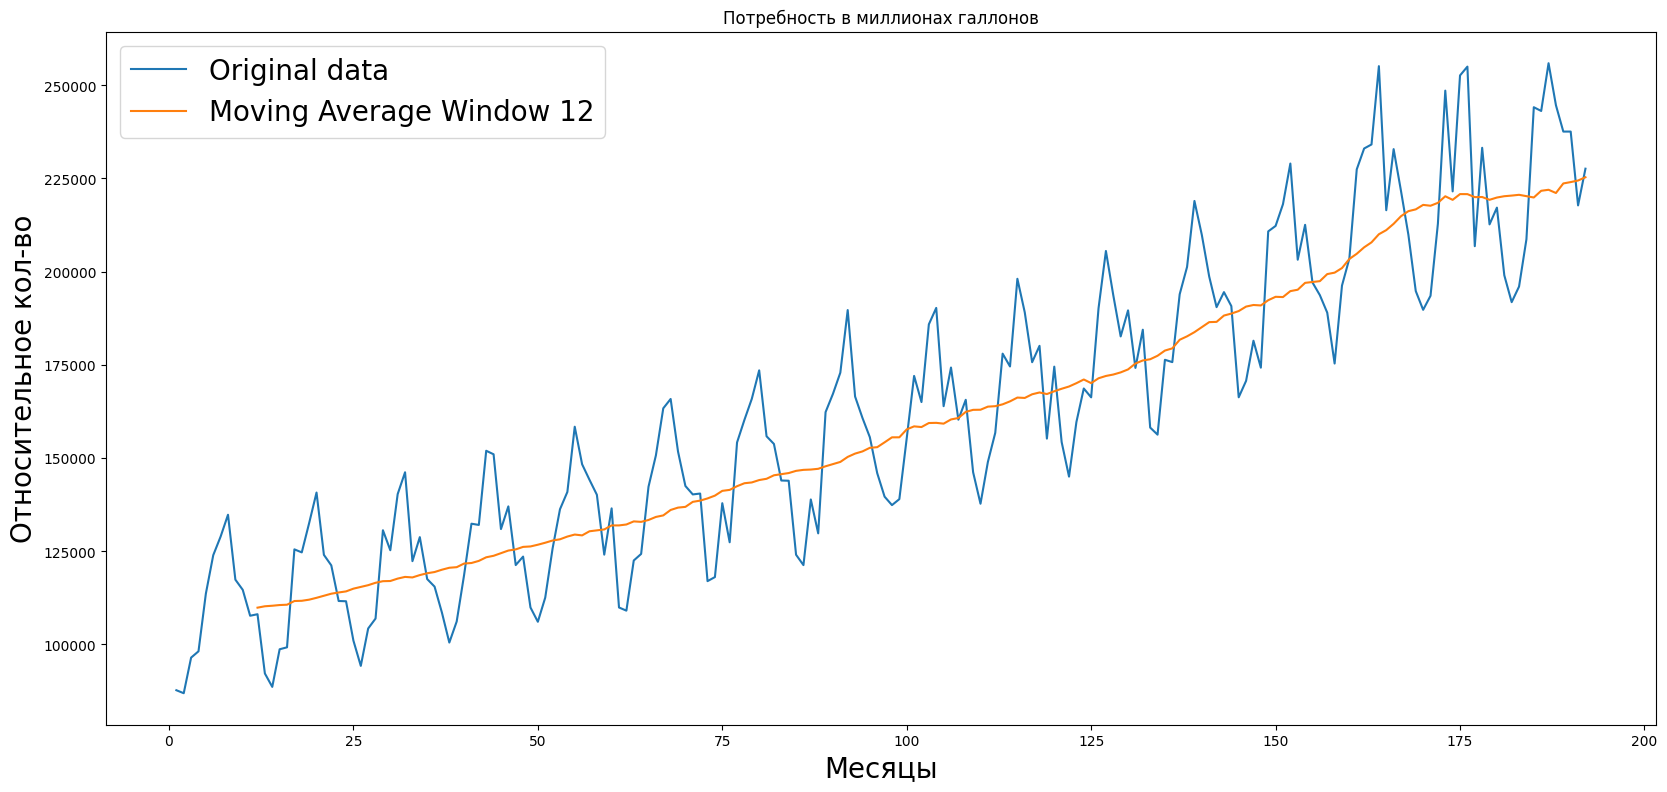

In [57]:
fig = plt.figure(figsize=(20, 9))
plt.plot(df['x'], label='Original data')
plt.plot(df['MA_window_12'], label='Moving Average Window 12')
plt.legend(fontsize="20")
plt.title('Потребность в миллионах галлонов')
plt.ylabel('Относительное кол-во', fontsize="20")
plt.xlabel('Месяцы', fontsize="20")
plt.show()

In [37]:
from statsmodels.tsa.arima.model import ARIMA

In [38]:
X = df['x'].values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]

In [39]:
%%capture
history = [x for x in train]
arma_predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arma_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [40]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

f_pred = arma_predictions

print("RMSE:", np.sqrt(mean_squared_error(test, f_pred)))
print("MAPE:", mean_absolute_percentage_error(test, f_pred))
print("MAE:", mean_absolute_error(test, f_pred))
print("R2: ", r2_score(test, f_pred))

RMSE: 18681.41894175007
MAPE: 0.0696760019993687
MAE: 15129.441357317715
R2:  0.3684795419596748


In [41]:
history = [x for x in train]
arima_predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [42]:
f_pred = arima_predictions

print("RMSE:", np.sqrt(mean_squared_error(test, f_pred)))
print("MAPE:", mean_absolute_percentage_error(test, f_pred))
print("MAE:", mean_absolute_error(test, f_pred))
print("R2: ", r2_score(test, f_pred))

RMSE: 18269.950794549808
MAPE: 0.06772572268896103
MAE: 14530.416382352667
R2:  0.3959923214289397


In [43]:
# Работа с пропусками

<Axes: >

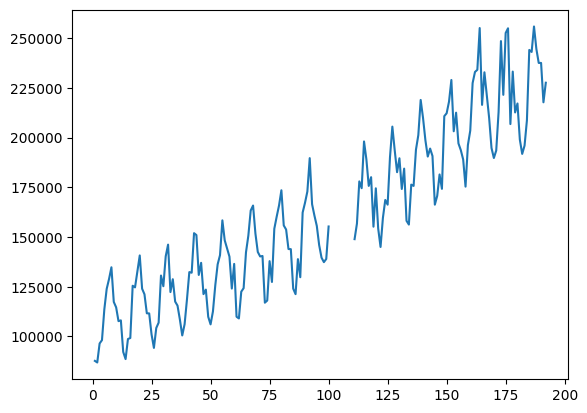

In [60]:
o_df = df['x'].copy()

o_df[100:110] = np.nan

o_df.plot()

<Axes: title={'center': 'Среднее из предыдущего и последующего'}>

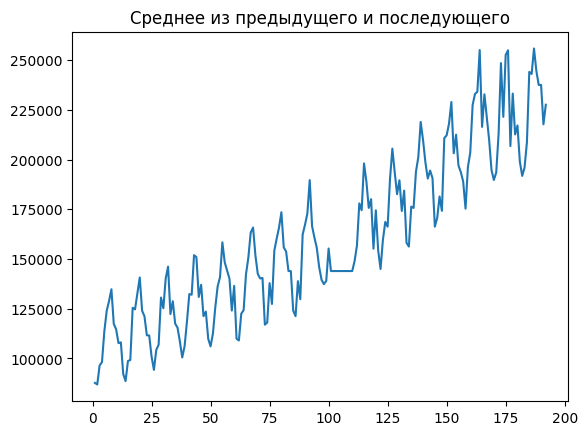

In [63]:
# Заполнение средним из предыдущего и последующего
new_value = (o_df[111] + o_df[99])/2

o_df[100:110] = new_value

o_df.plot(title="Среднее из предыдущего и последующего")

<Axes: title={'center': 'Последующее значение'}>

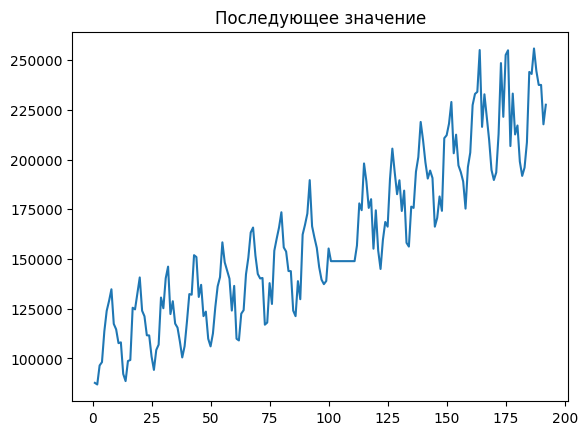

In [65]:
# Заполнение предыдущим и последующим значениями
new_value = o_df[111]

o_df[100:110] = new_value

o_df.plot(title='Последующее значение')

<Axes: title={'center': 'Предыдущее значение'}>

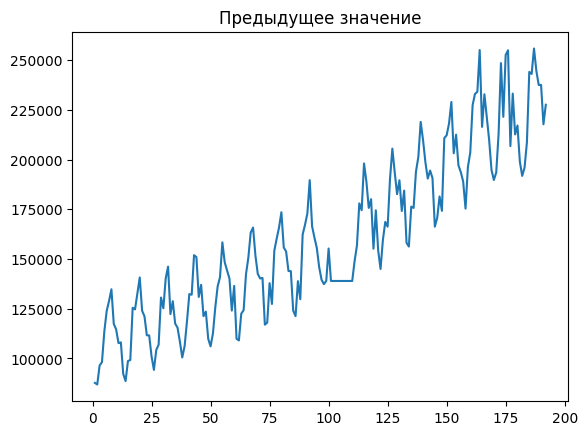

In [66]:
new_value = o_df[99]

o_df[100:110] = new_value

o_df.plot(title='Предыдущее значение')

<Axes: title={'center': 'Медиана'}>

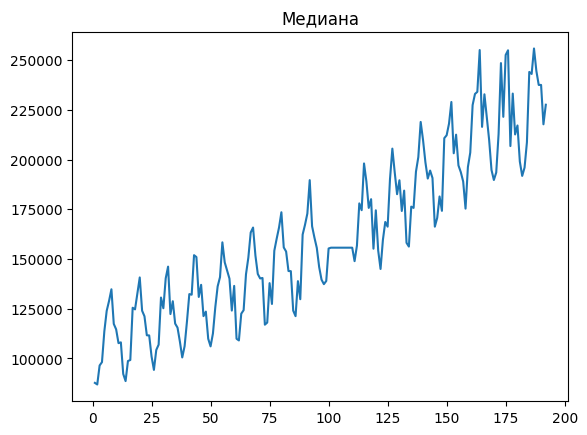

In [67]:
# Заполнение скользящим средним и медианой
o_df[100:110] = np.nan
new_value = o_df.median()

o_df[100:110] = new_value

o_df.plot(title='Медиана')

<Axes: title={'center': 'Среднее'}>

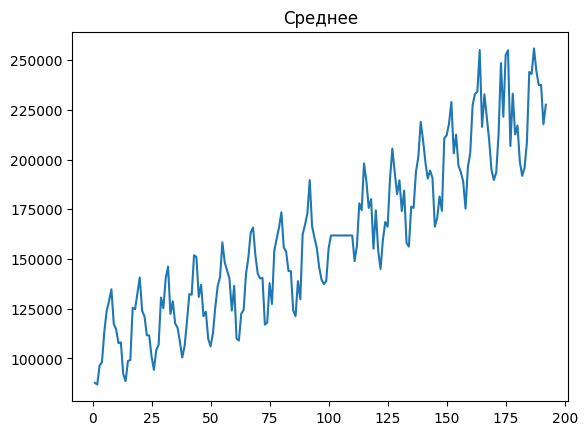

In [68]:
o_df[100:110] = np.nan
new_value = o_df.mean()

o_df[100:110] = new_value

o_df.plot(title='Среднее')

<Axes: title={'center': 'Zero'}>

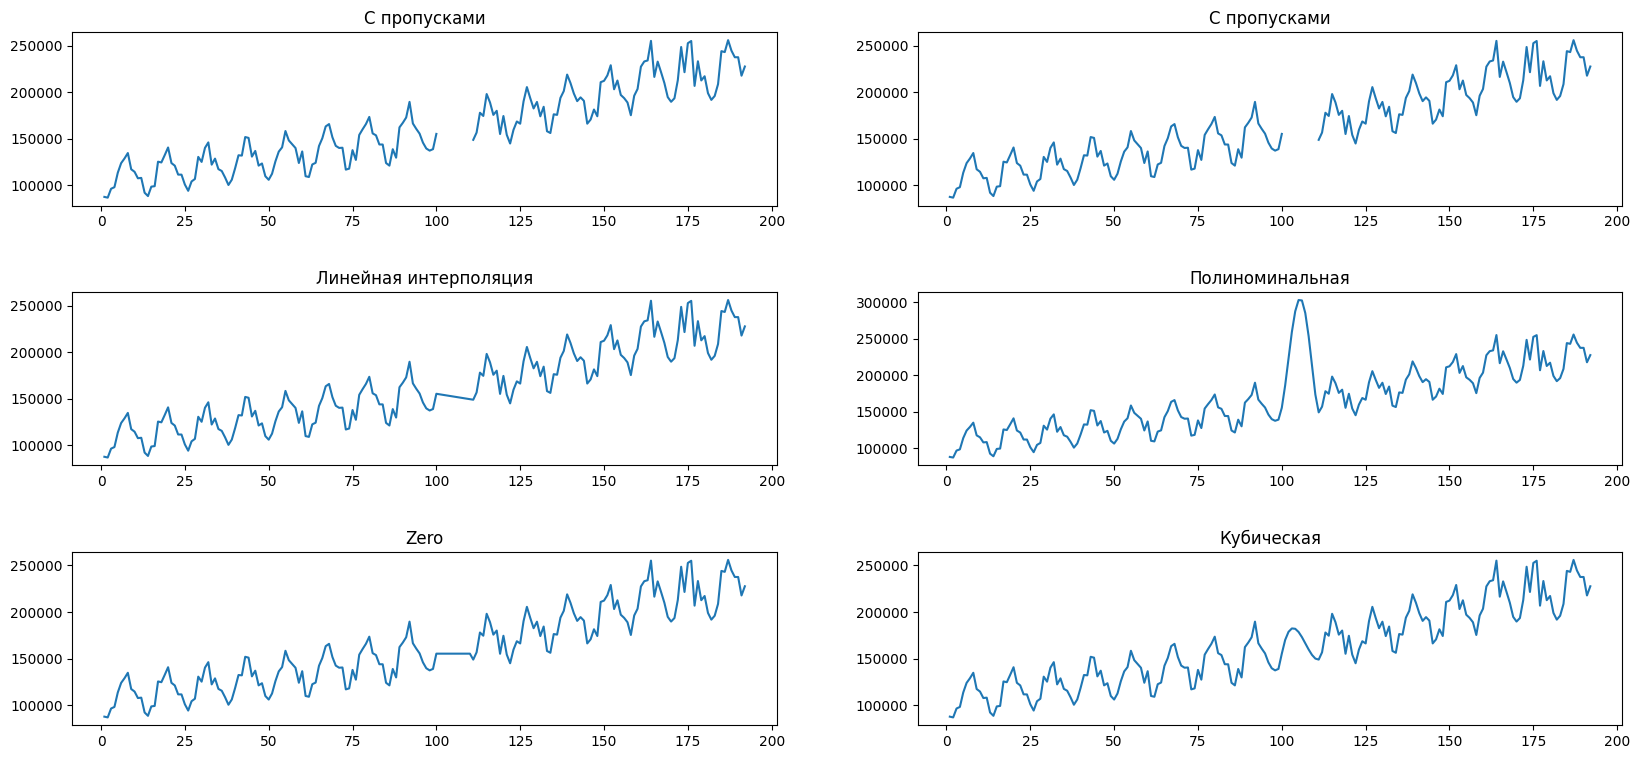

In [69]:
# Интерполяция разными алгоритмами
o_df[100:110] = np.nan

lin_df = o_df.interpolate(method="linear")

cub_df = o_df.interpolate(method="cubic")

pol_df = o_df.interpolate(method="polynomial", order=5)

zero_df = o_df.interpolate(method="zero")


fig = plt.figure(figsize=(20, 9))
layout = (3, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

original_ax = plt.subplot2grid(layout, (0, 0))
lin_ax = plt.subplot2grid(layout, (1, 0))
cub_ax = plt.subplot2grid(layout, (2, 1))

pol_ax = plt.subplot2grid(layout, (1, 1))
zero_ax = plt.subplot2grid(layout, (2, 0))

o_df.plot(title="С пропусками", ax = original_ax)
o_df.plot(title="С пропусками", ax = plt.subplot2grid(layout, (0, 1)))
lin_df.plot(title="Линейная интерполяция", ax = lin_ax)
cub_df.plot(title="Кубическая", ax = cub_ax)
pol_df.plot(title="Полиноминальная", ax = pol_ax)
zero_df.plot(title="Zero", ax=zero_ax)


In [70]:
# Поиск выбросов
import seaborn as sns
from sklearn import preprocessing, svm

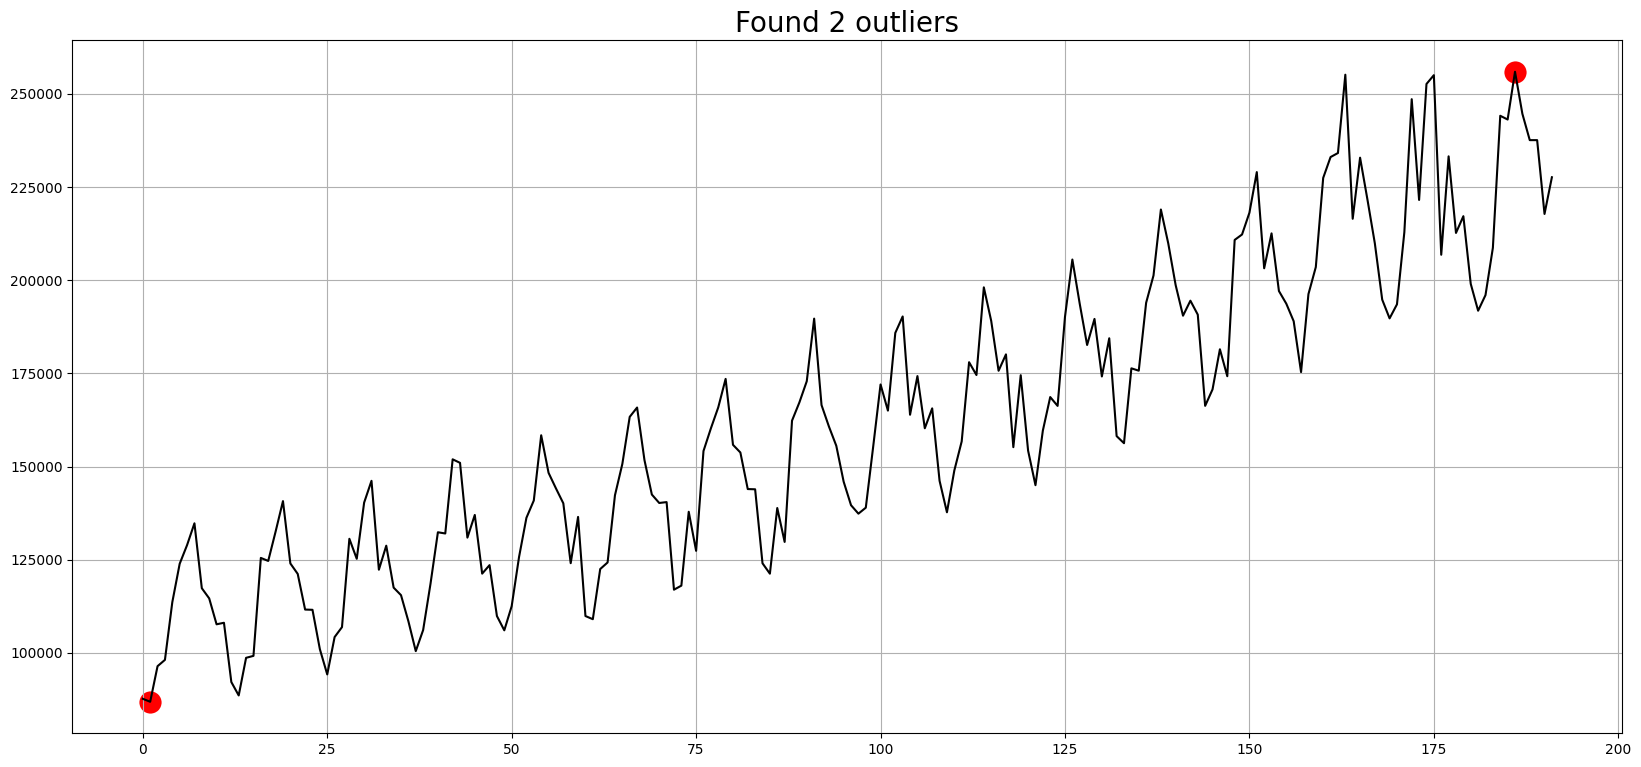

In [71]:
scaler = preprocessing.StandardScaler()
perc = 0.01

ecg = df.copy()

local_df = ecg["x"]

ts_scaled = scaler.fit_transform(local_df.values.reshape(-1,1))
model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
model.fit(ts_scaled)

dtf_outliers = local_df.to_frame(name="ts")
dtf_outliers["index"] = range(len(local_df))
dtf_outliers["outlier"] = model.predict(ts_scaled)
dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda x: 1 if x==-1 else 0)

fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(dtf_outliers["index"], dtf_outliers["ts"], color="black")
ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
           y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
           color='red', linewidths=10)
plt.title(f"Found {sum(dtf_outliers['outlier']==1)} outliers", fontdict={'fontsize': 20})
ax.grid(True)
plt.show()

In [72]:
dtf_outliers.head()

,ts,index,outlier
1,87695,0,0
2,86890,1,1
3,96442,2,0
4,98133,3,0
5,113615,4,0


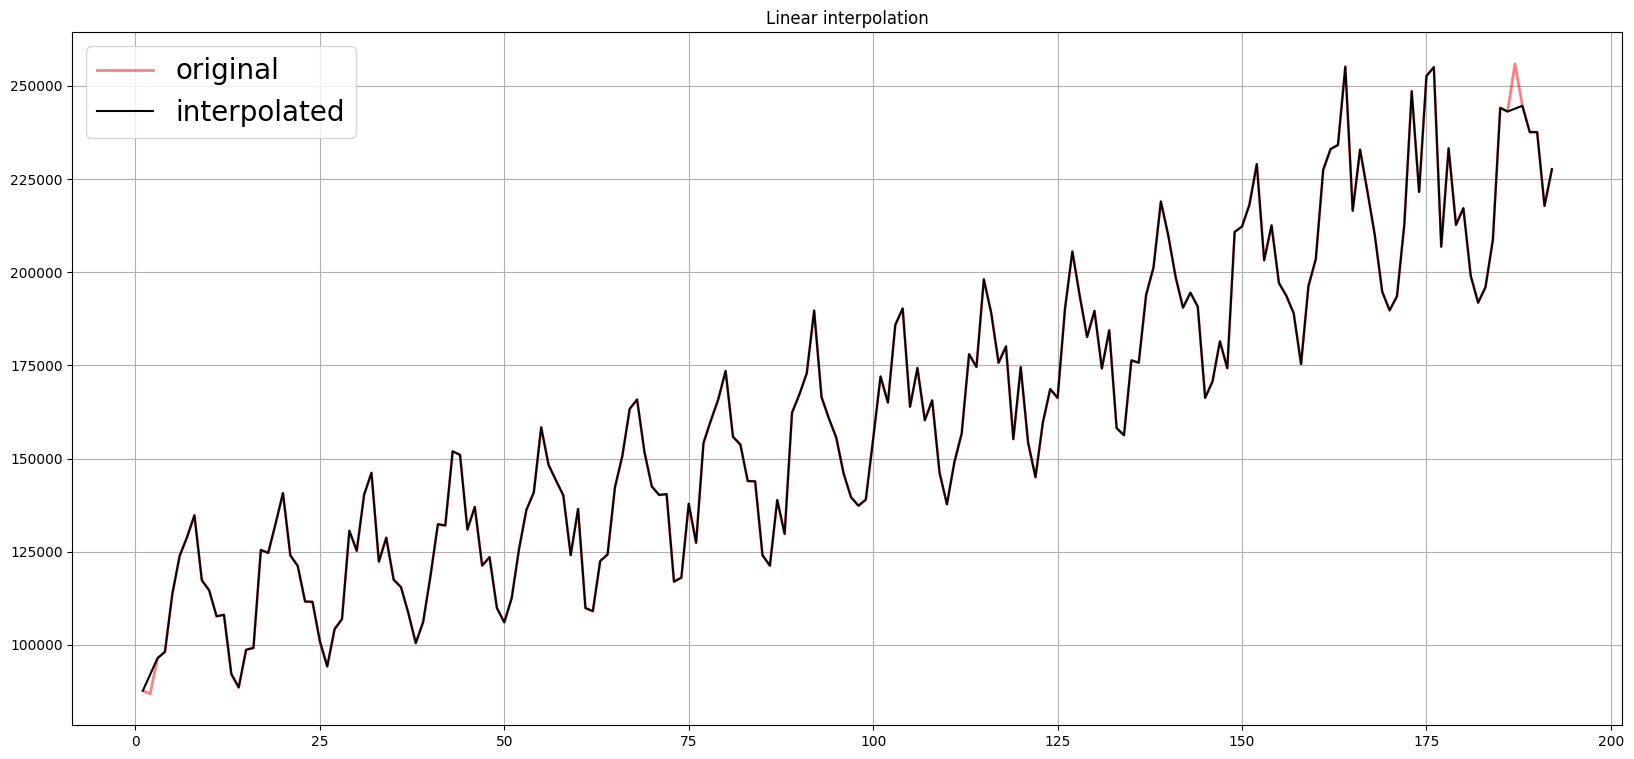

In [73]:
outliers_idx = dtf_outliers[dtf_outliers["outlier"]==1].index

ts_outliers_nan = local_df.copy()
ts_outliers_nan.loc[outliers_idx] = np.nan
ts_clean = ts_outliers_nan.interpolate(method="linear")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Linear interpolation", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()

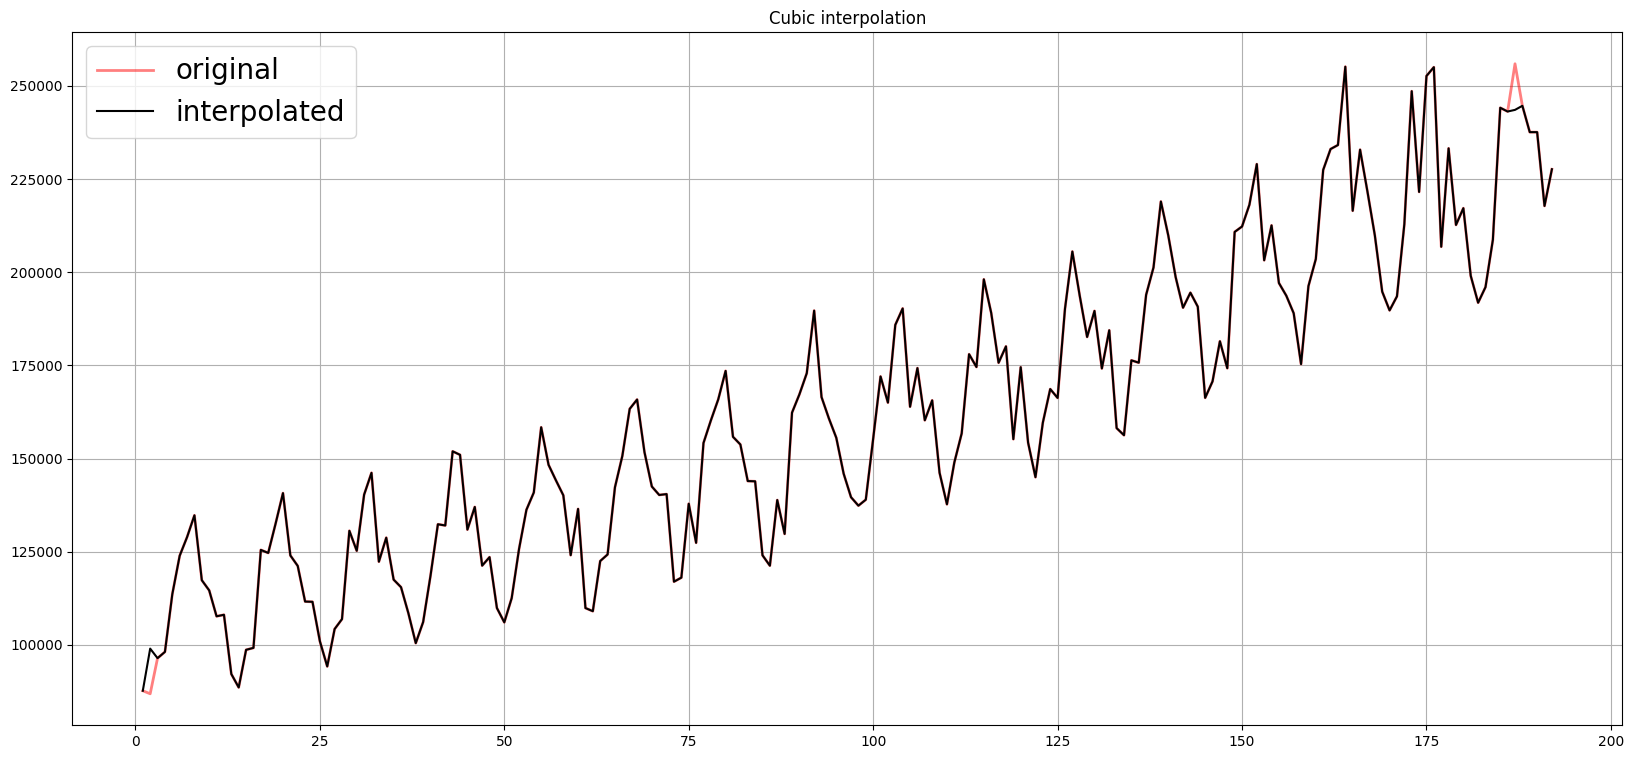

In [74]:
ts_outliers_nan = local_df.copy()
ts_outliers_nan.loc[outliers_idx] = np.nan
ts_clean = ts_outliers_nan.interpolate(method="cubic")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Cubic interpolation", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()

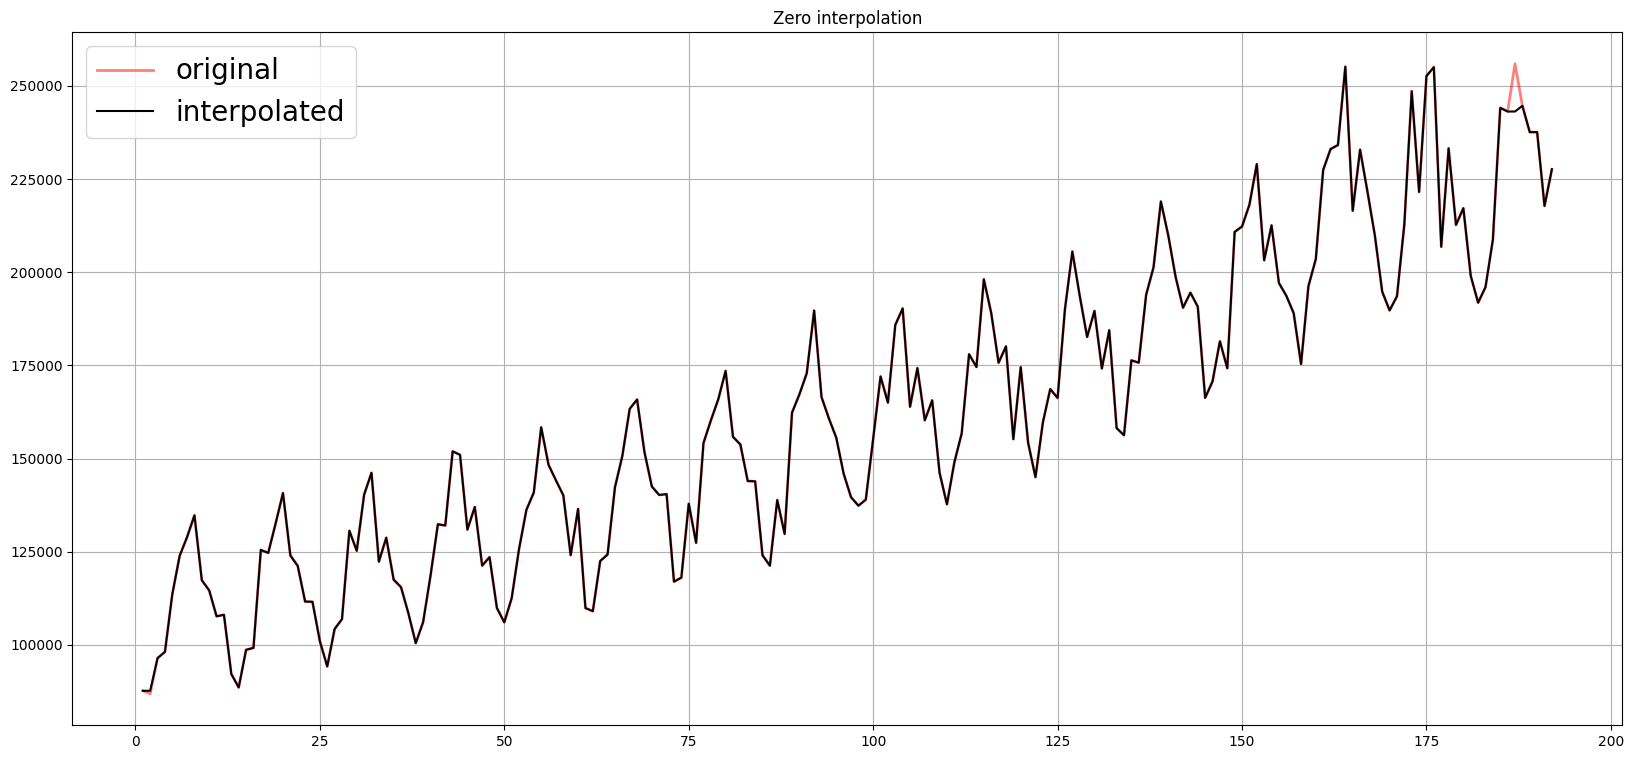

In [75]:
ts_outliers_nan = local_df.copy()
ts_outliers_nan.loc[outliers_idx] = np.nan
ts_clean = ts_outliers_nan.interpolate(method="zero")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Zero interpolation", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()